# Stereo SLAM

This is a major part of this project and will likely take some time. 

For stereo, feel free to look up existing tutorials that implement this and write your own code here. Do not spend too long tweaking parameters here, focus on getting decent results and move on. You can also use OpenCV functions to backproject to 3D. 

## PART 1: Stereo dense reconstruction

3-D point clouds are very useful in robotics for several tasks such as object detection, motion estimation (3D-3D matching or 3D-2D matching), SLAM, and other forms of scene understanding.  Stereo cameras provide  us  with  a  convenient  way  to  generate  dense  point  clouds. Dense here,  in  contrast  to sparse, means all the image points are used for the reconstruction.  In this part of the assignment you will be generating a dense 3D point cloud reconstruction of a scene from stereo images.

#### Procedure: 

<ol>
    <li> Generate a disparity map for each stereo pair.  Use OpenCV (e.g.  StereoSGBM) for this.  Note that the images provided are already rectified and undistorted. </li>
    <li> Then, using the camera parameters and baseline information generate colored point clouds from each disparity map.  Some points will have invalid disparity values, so ignore them.  Use [Open3D]for storing your point clouds. </li>
    <li> Register (or transform) all the generated point clouds into your world frame by using the provided ground truth poses. </li>
    <li> Visualize the registered point cloud data, in color.  Use Open3D for this </li>
</ol>
    
    
Write briefly about how the disparity map is generated (if you used SGBM, write about SGBM).

In [2]:
import numpy as np 
import cv2
from matplotlib import pyplot as plt
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
def reprojectImageTo3d(disparity,Q):
    points = []
    disparity_map = []
    for i in range(disparity.shape[0]):
        for j in range(disparity.shape[1]):
            disparity_map.append([j,i,disparity[i,j],1])
    for dis in disparity_map: points.append(np.dot(Q, dis))
    return np.array(points)

def find_disparity(imageL,imageR):
    stereo = cv2.StereoSGBM_create(minDisparity = -39,
        numDisparities = 144,
        disp12MaxDiff = 1,
        blockSize=5,
        P1= 8*3* 5**2,
        P2= 32*3*5**2,
        uniquenessRatio = 10,
        speckleWindowSize = 100,
        speckleRange = 32,
        preFilterCap= 63
        )
    disparity = stereo.compute(imageL, imageR).astype(np.float32)/64.0
    disparity = (disparity+39)/144
    return disparity

In [4]:
f = open('../data/poses.txt', 'r')
poses = np.loadtxt(f)
poses = poses.reshape(len(poses),3,4)
K = np.array([[7.070912e+02, 0.000000e+00, 6.018873e+02],
              [0.000000e+00, 7.070912e+02, 1.831104e+02],
              [0.000000e+00, 0.000000e+00, 1.000000e+00]])
f = K[0,0]
b = 0.53790448812
pcd = o3d.geometry.PointCloud()
combined_pcd = o3d.geometry.PointCloud()
[h, w] = [370, 1226] # Got from image shape
[m_start, m_end] = [-1500, 1500]
Q = np.array([[1, 0, 0, -w/2], [0, -1, 0, h/2], [0, 0, 0, f], [0, 0, 1/b, 0]])

for i in range(1):
    print (f"Running for 0000000{460+i}.png")
    imgL = cv2.imread("../data/img2/0000000"+str(460+i)+".png")
    imgR = cv2.imread("../data/img3/0000000"+str(460+i)+".png")
    disparity = find_disparity(imgL,imgR)
    point_cloud = reprojectImageTo3d(disparity,Q)
    colors = cv2.cvtColor(imgL, cv2.COLOR_BGR2RGB)
    colors = colors[disparity >= disparity.min()]
    colors = colors/255
    cloud_colors = np.array(colors)
    point_cloud[:,0] /= point_cloud[:,3]
    point_cloud[:,1] /= point_cloud[:,3] 
    point_cloud[:,2] /= point_cloud[:,3]
    point_cloud[:,3] /= point_cloud[:,3]
    point_cloud = (poses[i] @ point_cloud.T).T
    mask = ((m_start <= point_cloud[:,1]) & (point_cloud[:,1] < m_end) &
        (m_start <= point_cloud[:,2]) & (point_cloud[:,2] < m_end) &
        (m_start <= point_cloud[:,0]) & (point_cloud[:,0] < m_end))
    point_cloud = point_cloud[mask]
    cloud_colors = cloud_colors[mask]
    point_cloud[:,0] *= -1
    print(point_cloud)
    pcd.points = o3d.utility.Vector3dVector(point_cloud)
    pcd.colors = o3d.utility.Vector3dVector(cloud_colors)
    combined_pcd = combined_pcd + pcd

o3d.io.write_point_cloud("colored_op.pcd", combined_pcd)

Running for 0000000460.png
[[  -73.32315039   365.41804581 -1497.10207558]
 [  -71.52681643   365.35802145 -1495.74737141]
 [  -69.73183466   365.29804228 -1494.393687  ]
 ...
 [ 1159.50090035  -178.96237518  -552.42229799]
 [ 1159.66830133  -178.71266138  -551.21792152]
 [ 1160.09692791  -178.51198896  -550.17864367]]


True

In [5]:
output = o3d.io.read_point_cloud("colored_op.pcd")
o3d.visualization.draw_geometries([output])

### Write briefly about how the disparity map is generated (if you used SGBM, write about SGBM).

**Answer**  
# lorem ipsum lawda lassan
# lorem ipsum lawda lassan
# lorem ipsum lawda lassan
# lorem ipsum lawda lassan
# lorem ipsum lawda lassan
# lorem ipsum lawda lassan
# lorem ipsum lawda lassan



## PART 2: Motion estimation using iterative PnP

Using the generated reconstruction from the previous part, synthesize a new image taken by a virtualmonocular camera fixed at any arbitrary position and orientation.  Your task in this part is to recover this pose using an iterative Perspective-from-n-Points (PnP) algorithm. 

#### Procedure: 

<ol>
    <li> Obtain a set of 2D-3D correspondences between the the image and the point cloud.  Since here you’re generating the image, this should be easy to obtain. </li>
    <li> For this set of correspondences compute the total reprojection error c= $\sum_{i} ‖x_i−P_{k}X_i‖^2 $    where $P_{k}= K[R_{k}|t_{k}]$, $X_{i}$ is the 3D point in the world frame, $x_{i}$ is its corresponding projection. </li>
    <li> Solve for the pose $T_{k}$ that minimizes this non-linear reprojection error using a Gauss-Newton (GN)scheme.  Recall that in GN we start with some initial estimated value $x_{o}$ and iteratively refine the estimate using $x_{1}$= $∆x+x_0$, where $∆x$ is obtained by solving the normal equations $J^{T}J∆x$= -$J^{T}e$, until convergence.The main steps in this scheme are computing the corresponding Jacobians and updating the estimates correctly.  For our problem,  use a 12×1 vector parameterization for $T_{k}$(the top 3×4submatrix).  Run the optimization for different choices of initialization and report your observations. </li>
</ol>

Make sure that you write about how you calculate the residual and jacobians. Do not just include the code. The pose that you have been given is the ground truth, so using that will obviously give good results for optimization, so try out something else as well.


In [6]:
def AB(x, X):
    A = (np.vstack((x[:,0]*X[:,0],np.vstack((x[:,0]*X[:,1],np.vstack((x[:,0]*X[:,2],x[:,0]*X[:,3])))))))
    A = A.T
    B = (np.vstack((x[:,1]*X[:,0],np.vstack((x[:,1]*X[:,1],np.vstack((x[:,1]*X[:,2],x[:,1]*X[:,3])))))))
    B = B.T
    return A, B

def DLT(x,X):
    x[:,0] = x[:,0]/x[:,2]
    x[:,1] = x[:,1]/x[:,2]
    [A, B] = AB(x, X)
    M = np.vstack((np.hstack((-X,np.hstack((np.zeros(X.shape), A)))), np.hstack((np.zeros(X.shape), np.hstack((-X,B))))))
    U,D,VT = np.linalg.svd(M);
    P = np.array(VT[-1]).reshape(3,4);
    return P/P[-1,-1]

def Jacobian(x,X):
    X[:,0] = X[:,0]/x[:,2]
    X[:,1] = X[:,1]/x[:,2]
    X[:,2] = X[:,2]/x[:,2]
    X[:,3] = X[:,3]/x[:,2]
    x[:,0] = x[:,0]/x[:,2]
    x[:,1] = x[:,1]/x[:,2]
    [A, B] = AB(x, X)
    J = np.vstack((np.hstack((-X,np.hstack((np.zeros(X.shape),A)))), np.hstack((np.zeros(X.shape),np.hstack((-X,B))))))
    return J

def GaussNewton(P,x_gt,X,N,tol): 
    errors = []
    for i in range(N):
        x = np.dot(P, X.T)
        x = x.T
        A = x_gt[:,0]/x_gt[:,2] - x[:,0]/x[:,2]
        B = x_gt[:,1]/x_gt[:,2] - x[:,1]/x[:,2]
        J = Jacobian(x,X)
        R = (np.hstack((A,B))).reshape(-1,1)
        P = (P.reshape(12,1) - np.dot(np.dot(np.linalg.inv(np.dot(J.T, J)), J.T), R)).reshape(3,4)
        errors.append((R.T@R/2/len(X)).item(0))
        if (i%2==0): print(f"ITERATION {i+1}    COST {errors[i]}")
        if(np.linalg.norm(np.dot(np.dot(np.linalg.inv(np.dot(J.T, J)), J.T), R))<tol): break
    return P, errors

In [7]:
pcd_pts = np.asarray(output.points)
homo_points = np.hstack((pcd_pts,np.ones((pcd_pts.shape[0],1))))
homo_points = homo_points[0::10,:] # Downsample 10 times

T = np.eye(4,4)
T[:3,:4] = poses[0]
T = np.linalg.inv(T)
P_gt = K @ T[:3,:4]
print(" Projection matrix ground truth:\n", P_gt)

homo_img = (P_gt@ homo_points.T) # Image in 0th camera's frame 
homo_img = homo_img.T
P_init = DLT(homo_img[:10,:], homo_points[:10,:])
print("\n Projection matrix initialisation using DLT:\n", P_gt[-1,-1]*P_init)

 Projection matrix ground truth:
 [[-8.90929517e+02  5.38387637e+01 -2.56109933e+02 -1.53083396e+05]
 [-3.68165080e+01  7.13415332e+02 -1.52284250e+02  2.00006057e+01]
 [-4.11338164e-01  4.10740947e-02 -9.10556891e-01 -2.77880277e+01]]

 Projection matrix initialisation using DLT:
 [[-8.90929374e+02  5.38382431e+01 -2.56110052e+02 -1.53083393e+05]
 [-3.68164374e+01  7.13414870e+02 -1.52284349e+02  1.99945050e+01]
 [-4.11338117e-01  4.10739699e-02 -9.10556864e-01 -2.77880277e+01]]


ITERATION 1    COST 219258371343.52817
ITERATION 3    COST 3076626885019.3716
ITERATION 5    COST 7483847756.400477
ITERATION 7    COST 5424390.084377621
ITERATION 9    COST 77739.46446772033
ITERATION 11    COST 168.78208633726882
ITERATION 13    COST 24.266442622109462
ITERATION 15    COST 24.24469017921252
ITERATION 17    COST 24.244689289621025

Took 18 iterations

Optimized projection matrix:
[[-8.90910778e+02  5.38368670e+01 -2.56068533e+02 -1.53082179e+05]
 [-3.67717543e+01  7.13410876e+02 -1.52185201e+02  2.30101222e+01]
 [-4.11338164e-01  4.10740947e-02 -9.10556891e-01 -2.77880277e+01]]


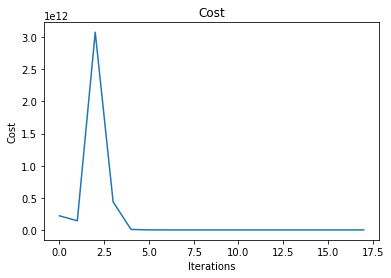

In [42]:
P_op, Cost = GaussNewton(P_init, homo_img, homo_points, 1000,1e-4)
P_op = P_gt[-1,-1]*(P_op/P_op[-1,-1]) 

print(f"\nTook {len(Cost)} iterations")
print("\nOptimized projection matrix:")
print(P_op)

plt.clf()
plt.plot(Cost)
plt.title('Cost')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

### Write briefly about how the disparity map is generated (if you used SGBM, write about SGBM).

**Answer**  
# lorem ipsum lawda lassan
# lorem ipsum lawda lassan
# lorem ipsum lawda lassan
# lorem ipsum lawda lassan
# lorem ipsum lawda lassan
# lorem ipsum lawda lassan
# lorem ipsum lawda lassan


## PART 3: Odometry Calculation

In part 1, you used the ground truth pose for registration. Here, try to estimate the pose using the RGB image data alone. 

#### Procedure:

1. This can be done by computing features across the two images and matching them. Since you already have the depth map, you now have correspondences between the depth maps of two images as well from the RGB feature matches. 
2. You can now convert this depth map to a point cloud.
3. Since you have correspondences between image points in the depth map, you have 3D correspondences here as well. Perform ICP here to get a good pose estimate.
4. Feed these initial pose estimates into the PnP pipeline and optimise further.

In [ ]:
img1_pts = np.array([[594.43785784,  50.18100824],
 [798.17197319, 217.96204441],
 [384.71156263, 270.17961179],
 [288.83668482, 294.14833124],
 [856.38172043, 223.09819858],
 [263.15591398,  64.73344505],
 [456.61772099,  50.18100824]])

img2_pts = np.array([[ 710.00132663,   45.04485407],
 [ 953.96864963,  235.938584  ],
 [ 478.01836336,  280.45192012],
 [ 375.29527999,  306.98871666],
 [1031.01096216,  245.35486664],
 [ 370.15912582,   64.73344505],
 [ 561.90888144,   45.90087977]]
)

img1_pts = img1_pts.round(0)
img2_pts = img2_pts.round(0)
img1_pts = img1_pts.astype(int)
img2_pts = img2_pts.astype(int)

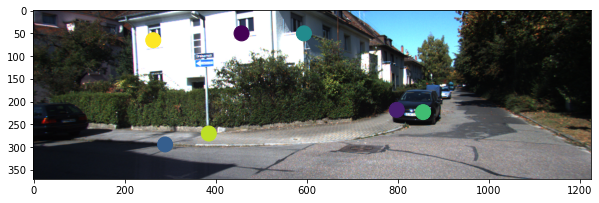

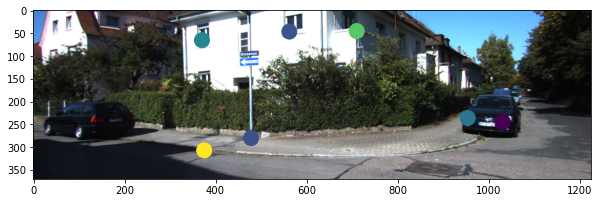

In [25]:
%matplotlib inline

image_points = img1_pts
N = len(image_points)
image_points = np.array(image_points)
fig = plt.figure(figsize=(10,15))
img=mpimg.imread('../data/img2/0000000460.png')
imgplot = plt.imshow(img)
colors = np.random.rand(N)
area = (15 * np.ones(N))**2 
plt.scatter(image_points[:,0], image_points[:,1], c=colors, s=area)
plt.show()

image_points = img2_pts
N = len(image_points)
image_points = np.array(image_points)
fig = plt.figure(figsize=(10,15))
img=mpimg.imread('../data/img2/0000000463.png')
imgplot = plt.imshow(img)
colors = np.random.rand(N)
area = (15 * np.ones(N))**2 
plt.scatter(image_points[:,0], image_points[:,1], c=colors, s=area)
plt.show()

In [29]:
def _reprojectImageTo3d(disparity,Q, img_pts):
    points = []
    disparity_map = []
    for k in range(len(img_pts)):
        i = img_pts[k][1]
        j = img_pts[k][0]
        disparity_map.append([j,i,disparity[i,j],1])
    for dis in disparity_map: points.append(np.dot(Q, dis))
    return np.array(points)

imgL = cv2.imread("../data/img2/0000000460.png")
imgR = cv2.imread("../data/img3/0000000460.png")
disparity = find_disparity(imgL,imgR)
point_cloud = _reprojectImageTo3d(disparity,Q, img1_pts)
point_cloud[:,0] = point_cloud[:,0] / point_cloud[:,3]
point_cloud[:,1] = point_cloud[:,1] / point_cloud[:,3]
point_cloud[:,2] = point_cloud[:,2] / point_cloud[:,3]
point_cloud[:,3] = point_cloud[:,3] / point_cloud[:,3]
point_cloud1 = point_cloud.copy()

imgL = cv2.imread("../data/img2/0000000463.png")
imgR = cv2.imread("../data/img3/0000000463.png")
disparity = find_disparity(imgL,imgR)
point_cloud = _reprojectImageTo3d(disparity,Q, img1_pts)
point_cloud[:,0] = point_cloud[:,0] / point_cloud[:,3]
point_cloud[:,1] = point_cloud[:,1] / point_cloud[:,3]
point_cloud[:,2] = point_cloud[:,2] / point_cloud[:,3]
point_cloud[:,3] = point_cloud[:,3] / point_cloud[:,3]
point_cloud2 = point_cloud.copy()

print("3D Points from 0000000460.png")
print(point_cloud1)
print("\n3D Points from 0000000463.png")
print(point_cloud2)

3D Points from 0000000460.png
[[-3.30953006e+01  2.35150820e+02  1.23165241e+03  1.00000000e+00]
 [ 3.13219128e+02 -5.58715202e+01  1.19715940e+03  1.00000000e+00]
 [-3.79922950e+02 -1.41637942e+02  1.17824638e+03  1.00000000e+00]
 [-5.25580582e+02 -1.76815690e+02  1.14701668e+03  1.00000000e+00]
 [ 4.11136756e+02 -6.42929907e+01  1.19634231e+03  1.00000000e+00]
 [-6.23451196e+02  2.13754696e+02  1.25953387e+03  1.00000000e+00]
 [-2.74040809e+02  2.37150701e+02  1.24212721e+03  1.00000000e+00]]

3D Points from 0000000463.png
[[-3.30025321e+01  2.34491675e+02  1.22820000e+03  1.00000000e+00]
 [ 3.09623777e+02 -5.52301872e+01  1.18341756e+03  1.00000000e+00]
 [-3.81590384e+02 -1.42259573e+02  1.18341756e+03  1.00000000e+00]
 [-5.30791197e+02 -1.78568643e+02  1.15838822e+03  1.00000000e+00]
 [ 4.11839537e+02 -6.44028906e+01  1.19838729e+03  1.00000000e+00]
 [-6.31162110e+02  2.16398438e+02  1.27511192e+03  1.00000000e+00]
 [-2.74040809e+02  2.37150701e+02  1.24212721e+03  1.00000000e+00]]

In [36]:
def Procrustes(X, P):
    n = X.shape[1]
    dim = X.shape[0]
    T = np.identity(4)
    error = np.sqrt(np.sum(np.square(X-P)) / X.shape[1])
    print('Initial error: '+str(error))
    for iteration in range(1):
        W = np.zeros((3,3))
        point_cloud1_mean = np.mean(X, axis = 1, keepdims = True)
        point_cloud2_mean = np.mean(P, axis = 1, keepdims = True)
        for idx in range(n):
            point1 = X[:, idx]
            point1 = point1.reshape(3,1)
            arr1 = point1 - point_cloud1_mean
            point2 = P[:, idx]
            point2 = point2.reshape(3,1)
            arr2 = point2 - point_cloud2_mean
            W = W+np.dot(arr1,arr2.T)
        W = W/n
        U, S, Vt = np.linalg.svd(W)
        R = np.dot(U,Vt)
        if np.linalg.det(R) < 0:
            Vt[dim - 1, :]*=-1
            R = U @ Vt
        t = point_cloud1_mean - np.dot( R , point_cloud2_mean)
        T_itr = R
        T_itr = np.append(T_itr, t, axis=1)
        T_itr = np.vstack([T_itr, [0, 0, 0, 1]])
        T = np.dot(T_itr, T)
        P = np.dot(R, P) + t
        error = np.sqrt(np.sum(np.square(X-P)) / X.shape[1])
    print(f"Error after alignment: {error}")
    return T

In [39]:
point_cloud1.shape

T = Procrustes(point_cloud1[:,:3].T, point_cloud2[:,:3].T)
print("\nTransformation obtained: ")
print(T)

Initial error: 10.126294229902673
Error after alignment: 6.356914822576555

Transformation obtained: 
[[ 9.99819724e-01  1.95403948e-04 -1.89863689e-02  2.54190480e+01]
 [-3.39424166e-04  9.99971195e-01 -7.58252710e-03  9.09989057e+00]
 [ 1.89843403e-02  7.58760458e-03  9.99790990e-01  6.22250736e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [41]:
# # For visualizing how aligned points look
# X = point_cloud1[:,:3].T
# X = X
# P1 = point_cloud2.T
# P1 = np.dot(T, P1)
# P1 = P1[:3]
# pcd = o3d.geometry.PointCloud()
# pcd1 = o3d.geometry.PointCloud()
# pcd = o3d.geometry.PointCloud()
# pcd.points = o3d.utility.Vector3dVector(X.T)
# pcd.paint_uniform_color([1, 0, 0])
# pcd1.points = o3d.utility.Vector3dVector(P1.T)
# pcd1.paint_uniform_color([0, 0, 1])
# o3d.visualization.draw_geometries([pcd,pcd1],)